# Emojitranslate project

## Part one - learning to predict emojis from tweets

The following code adapted from the Osinga deep learning cookbook - using the Twitter API to sample EN language tweets that contain exactly one emoji

In [1]:
import random
import twitter
import emoji
# import itertools
import pandas as pd
from itertools import chain
from keras.preprocessing.sequence import pad_sequences
import numpy as np
#from sklearn.model_selection import train_test_split
from keras import Sequential, optimizers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
import keras.callbacks
from keras.backend import clear_session
#import json

import os
# import nb_utils
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalMaxPooling1D#, Merge 
from keras.models import Model
from keras.layers.merge import Concatenate, Average

# from gensim.models import Word2Vec

Using TensorFlow backend.


In [2]:
all_tweets = pd.read_csv('data/emojis_homemade.csv')
all_tweets['emoji'].value_counts()

/home/nick/anaconda3/envs/emojitranslate-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


😂        70866
😭        28812
❤        23972
emoji    16415
😍        15831
🔥        15568
🤣         9882
🙏         7845
😩         7839
💕         7483
🤔         7383
😊         6750
🖤         6194
✨         6092
👀         5923
💜         5901
👏         5669
🙄         5466
💀         5268
🙌         5224
🎉         5051
😘         4719
💯         4661
💙         4519
♥         4143
😔         4112
👍         4018
👇         3816
😉         3755
🚨         3652
         ...  
⏺            2
㊗            1
🚟            1
🕠            1
🏬            1
🚇            1
🤼            1
🤾            1
🀄            1
🕟            1
🧘            1
📤            1
⚱            1
🈳            1
◀            1
🗃            1
🚳            1
👝            1
🈲            1
🏣            1
🧙            1
🚋            1
🈵            1
🕜            1
🕦            1
🕍            1
📏            1
🛢            1
🔡            1
➗            1
Name: emoji, Length: 1086, dtype: int64

In [3]:
all_tweets.shape

(729680, 3)

In [4]:
all_tweets.head

<bound method NDFrame.head of        Unnamed: 0                                               text emoji
0               0  RT @mydear_bangtan: [VID] 181023 - Foi adicion...     ©
1               1  RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...     💫
2               2  RT @TrendsPrabhas: Now you are watching Indian...     😎
3               3                                    dats for keeps      💛
4               4  RT @xruiztru: WHO ARMS THE SAUDIS?\n\n  🇺🇸US 5...     🏳
5               5  RT @xxxfreaknasty2: interracial couple go at i...     🌝
6               6               @Eric_Deshaun Holy shit no I think.      😩
7               7     RT @fanmutuals: army, follow who retweet this      👑
8               8  RT @_Simplykpop: Simply K-Pop harddrive dump\n...     🤩
9               9  Happy birthday nellie @thelittlegend, hope you...     ❤
10             10  RT @montparnasty: "I have passed through fire"...     💕
11             11  RT @Jason_Mckeown: Look how empty Valley Parad...  

Now let's filter these to only include emojis with more than 1000 examples 

In [29]:
tweets = all_tweets.groupby('emoji').filter(lambda c:len(c) > 1000)
tweets['emoji'].value_counts()

😂        70866
😭        28812
❤        23972
emoji    16415
😍        15831
🔥        15568
🤣         9882
🙏         7845
😩         7839
💕         7483
🤔         7383
😊         6750
🖤         6194
✨         6092
👀         5923
💜         5901
👏         5669
🙄         5466
💀         5268
🙌         5224
🎉         5051
😘         4719
💯         4661
💙         4519
♥         4143
😔         4112
👍         4018
👇         3816
😉         3755
🚨         3652
         ...  
😄         1350
😇         1340
🔴         1333
🤤         1330
🌹         1327
⚡         1316
✔         1279
😜         1259
😐         1242
✈         1241
✊         1184
💦         1160
😑         1152
😴         1149
👊         1129
🙈         1127
😕         1125
❣         1105
😞         1088
💘         1065
⭐         1058
📽         1055
❗         1054
🔗         1044
📍         1044
🤯         1039
💫         1027
⚠         1022
🤞         1013
🌟         1012
Name: emoji, Length: 112, dtype: int64

In [197]:
# Now re-index the data frame
tweets.reset_index(inplace=True)

so how big is our potential training set?

In [198]:
len(tweets)

461544

What proportion of these are the most common emoji? (crying with laughter 😂)

In [199]:
tweets['emoji'].value_counts()[0]/sum(tweets['emoji'].value_counts())

0.15354115750610992

In [200]:
max(tweets['text'], key=lambda t:len(t))

'RT @JoanKareri: A guy who smells good and leaves you with his scent after he leaves&gt;&gt;&gt;&gt; &gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;&gt;'

In [201]:
chars = list(sorted(set(chain(*tweets['text']))))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
max_sequence_len = max(len(x) for x in tweets['text'])

emojis = list(sorted(set(tweets['emoji'])))
emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
emojis[:10]

#train_tweets, test_tweets = train_test_split(tweets, test_size=0.1)

['emoji', '©', '‼', '▶', '☹', '☺', '♥', '⚠', '⚡', '✅']

Currently we've collected quite a lot of tweet data, so to speed up the prototyping of the model we're going to create a train/dev/test datasets of 10,000 tweets each.

In [202]:
#train_tweets = tweets[0:10000]
#dev_tweets = tweets[10000:20000]
#test_tweets = tweets[20000:30000]


# !! Temp! Try on much bigger dataset
train_tweets = tweets[0:100000] # 100000 tweets
dev_tweets = tweets[100000:110000]
test_tweets = tweets[110000:120000]

# Try on 400k tweets
#train_tweets = tweets[0:400000] # 100000 tweets
#dev_tweets = tweets[400000:420000]
#test_tweets = tweets[420000:440000]


In [203]:
#def data_generator(tweets, batch_size):
#    while True:
#        if batch_size is None:
#            batch = tweets
#            batch_size = batch.shape[0]
#        else:
#            batch = tweets.sample(batch_size)
#        X = np.zeros((batch_size, max_sequence_len, len(chars)))
#        y = np.zeros((batch_size,))
#        for row_idx, (_, row) in enumerate(batch.iterrows()):
#            y[row_idx] = emoji_to_idx[row['emoji']]
#            for ch_idx, ch in enumerate(row['text']):
#                X[row_idx, ch_idx, char_to_idx[ch]] = 1
#        yield X, y
#
#next(data_generator(tweets, 10))

In [204]:
#def create_char_cnn_model(num_chars, max_sequence_len, num_labels):
#    char_input = Input(shape=(max_sequence_len, num_chars), name='char_cnn_input')
#    
#    conv_1x = Conv1D(128, 6, activation='relu', padding='valid')(char_input)
#    max_pool_1x = MaxPooling1D(4)(conv_1x)
#    conv_2x = Conv1D(256, 6, activation='relu', padding='valid')(max_pool_1x)
#    max_pool_2x = MaxPooling1D(4)(conv_2x)

#    flatten = Flatten()(max_pool_2x)
#    dense = Dense(128, activation='relu')(flatten)
#    preds = Dense(num_labels, activation='softmax', name='char_cnn_predictions')(dense)

#    model = Model(char_input, preds)
#    model.compile(loss='sparse_categorical_crossentropy',
#                  optimizer='rmsprop',
#                  metrics=['acc'])
#    return model

#char_cnn_model = create_char_cnn_model(len(char_to_idx), max_sequence_len, len(emojis))
#char_cnn_model.summary()

In [205]:
#early = keras.callbacks.EarlyStopping(monitor='loss',
#                              min_delta=0.03,
#                              patience=2,
#                              verbose=1, mode='auto')

#checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_cnn.h5',
#                                             monitor='val_acc',
#                                             save_best_only = True)

#tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
#                                         histogram_freq=1,
#                                         embeddings_freq=1)

#BATCH_SIZE = 512
#char_cnn_model.fit_generator(
#    data_generator(train_tweets, batch_size=BATCH_SIZE),
#    validation_data = data_generator(dev_tweets, batch_size=BATCH_SIZE),
#    validation_steps=int(dev_tweets.shape[0]/BATCH_SIZE),
#    epochs=5,
#    steps_per_epoch=len(train_tweets) / BATCH_SIZE,
#    verbose=1, # was: verbose=2
#    callbacks=[early, checkpoint]
#)

In [206]:
#pd.options.display.max_colwidth = 128
#inspect_tweets = dev_tweets.sample(100)
#predicted = char_cnn_model.predict_generator(data_generator(inspect_tweets, batch_size=None), steps=1)
#show = pd.DataFrame({
#    'text': inspect_tweets['text'],
#    'true': inspect_tweets['emoji'],
#    'pred': [emojis[np.argmax(x)] for x in predicted],
#})
#show = show[['text', 'true', 'pred']]
#show.head(10)

# Simple neural network - single Dense layer

Benchmark performance with the simplest neural network we can get

Let's divide up the train/dev/test sets so we're not relying on a generator

In [207]:
x_train = train_tweets["text"]
y_train = np.asarray(train_tweets["emoji"])
x_dev = dev_tweets["text"]
y_dev = np.asarray(dev_tweets["emoji"])
x_test = test_tweets["text"]
y_test = np.asarray(test_tweets["emoji"])

all_emojis = np.concatenate((y_train, y_dev, y_test), axis=0)

emoji_to_idx = {em: idx for idx, em in enumerate(emojis)}
#emojis[:10]

all_emojis_idx = np.zeros(all_emojis.shape[0])

for i in range (all_emojis.shape[0]):
    all_emojis_idx[i] = emoji_to_idx[all_emojis[i]]    

all_emojis_one_hot = to_categorical (all_emojis_idx)
    
#y_train_idx = all_emojis_one_hot[0:10000,:]
#y_dev_idx = all_emojis_one_hot[10000:20000,:]
#y_test_idx = all_emojis_one_hot[20000:30000,:]


# Temp!
y_train_idx = all_emojis_one_hot[0:100000,:]
y_dev_idx = all_emojis_one_hot[100000:110000,:]
y_test_idx = all_emojis_one_hot[110000:120000,:]


# Temp!
#y_train_idx = all_emojis_one_hot[0:400000,:]
#y_dev_idx = all_emojis_one_hot[400000:420000,:]
#y_test_idx = all_emojis_one_hot[420000:440000,:]

In [208]:
# y_train_idx[0:10]

Now let's start by one-hot encoding the text samples

In [209]:
num_words = 5000


tokenizer = Tokenizer(num_words = num_words) # was: 1000
tokenizer.fit_on_texts (x_train)

#x_train_sequences = tokenizer.texts_to_sequences(x_train)
#x_dev_sequences = tokenizer.texts_to_sequences(x_dev)
#x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_one_hot = tokenizer.texts_to_matrix(x_train, mode='binary')
x_dev_one_hot = tokenizer.texts_to_matrix(x_dev, mode='binary')
x_test_one_hot = tokenizer.texts_to_matrix(x_test, mode='binary')




# remember to pad sequences

In [210]:
x_train_one_hot.shape

(100000, 5000)

In [211]:
y_train_idx.shape

(100000, 112)

In [212]:
tokenizer.word_index

{'rt': 1,
 'https': 2,
 't': 3,
 'co': 4,
 'the': 5,
 'i': 6,
 'to': 7,
 'you': 8,
 'a': 9,
 'my': 10,
 'this': 11,
 'and': 12,
 'is': 13,
 'for': 14,
 'of': 15,
 'in': 16,
 'it': 17,
 'me': 18,
 'on': 19,
 'so': 20,
 'that': 21,
 'with': 22,
 'be': 23,
 'at': 24,
 '️': 25,
 'love': 26,
 'like': 27,
 'bts': 28,
 'all': 29,
 'we': 30,
 'your': 31,
 'just': 32,
 'was': 33,
 'are': 34,
 'text': 35,
 'if': 36,
 'i’m': 37,
 'now': 38,
 'who': 39,
 'but': 40,
 'have': 41,
 'back': 42,
 'u': 43,
 'twt': 44,
 'got': 45,
 'get': 46,
 'new': 47,
 'not': 48,
 'out': 49,
 'when': 50,
 'amp': 51,
 'he': 52,
 'one': 53,
 'up': 54,
 'do': 55,
 'what': 56,
 'they': 57,
 'will': 58,
 'can': 59,
 '…': 60,
 'from': 61,
 'see': 62,
 'good': 63,
 'about': 64,
 'his': 65,
 'know': 66,
 'how': 67,
 'no': 68,
 'day': 69,
 'don’t': 70,
 'her': 71,
 'thank': 72,
 'happy': 73,
 'she': 74,
 'follow': 75,
 'as': 76,
 'tweet': 77,
 'time': 78,
 'go': 79,
 'steveaoki': 80,
 'has': 81,
 'coming': 82,
 'our': 83,
 'to

# A linear classifier

As a performance baseline for more complex models, it's instructive to see how well we can do with just a linear classifier with no hidden layer. With 64 hidden units trained on 10,000 training examples, we're able to get up to about 38% accuracy on the validation set. A lower learning rate slows down the learning (although it's still very fast) but doesn't appear to do any better in terms of final accuracy before the model starts overfitting. 

In [213]:
y_dev_idx.shape

(10000, 112)

In [113]:
output_size = y_dev_idx.shape[1] # around 64 units for 10,000 tweets

model = Sequential()
model.add(Dense(output_size, activation='softmax', input_shape=(num_words,))) 
model.compile(optimizer=optimizers.RMSprop(lr = 0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    verbose=2)

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
 - 2s - loss: 3.4076 - acc: 0.3397 - val_loss: 2.9759 - val_acc: 0.3913
Epoch 2/20
 - 1s - loss: 2.5572 - acc: 0.4378 - val_loss: 2.7187 - val_acc: 0.4269
Epoch 3/20
 - 1s - loss: 2.2569 - acc: 0.4749 - val_loss: 2.6683 - val_acc: 0.4348
Epoch 4/20
 - 1s - loss: 2.1046 - acc: 0.4976 - val_loss: 2.6737 - val_acc: 0.4382
Epoch 5/20
 - 1s - loss: 2.0086 - acc: 0.5118 - val_loss: 2.7048 - val_acc: 0.4390
Epoch 6/20
 - 1s - loss: 1.9411 - acc: 0.5216 - val_loss: 2.7410 - val_acc: 0.4418
Epoch 7/20
 - 1s - loss: 1.8902 - acc: 0.5296 - val_loss: 2.7819 - val_acc: 0.4403
Epoch 8/20
 - 1s - loss: 1.8505 - acc: 0.5355 - val_loss: 2.8230 - val_acc: 0.4352
Epoch 9/20
 - 1s - loss: 1.8169 - acc: 0.5404 - val_loss: 2.8647 - val_acc: 0.4374
Epoch 10/20
 - 1s - loss: 1.7879 - acc: 0.5456 - val_loss: 2.9066 - val_acc: 0.4367
Epoch 11/20
 - 1s - loss: 1.7636 - acc: 0.5500 - val_loss: 2.9472 - val_acc: 0.4378
Epoch 12/20
 - 1s - loss: 1.7422 -

In [114]:
import matplotlib.pyplot as plt

def plot_train_history(history): 

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot (epochs, acc, 'bo', label='Training acc')
    plt.plot (epochs, val_acc, 'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

best validation accuracy:  0.4417999997138977


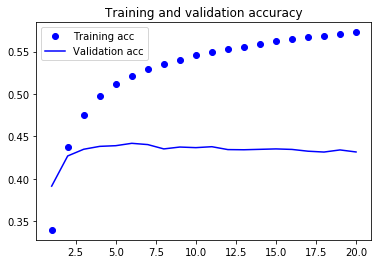

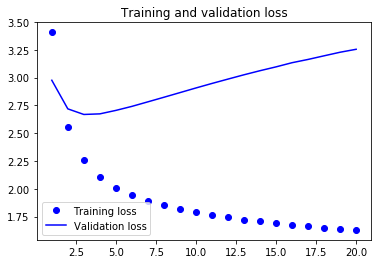

In [115]:
print ("best validation accuracy: ", max(history.history['val_acc']))
plot_train_history(history)

# Shallow neural network
A simple shallow neural network with a layer of hidden units

128 hidden units gets us up to 39% accuracy

Train on 100000 samples, validate on 10000 samples
Epoch 1/30
100000/100000 [==============================] - 1s 14us/step - loss: 3.5519 - acc: 0.3020 - val_loss: 3.0528 - val_acc: 0.3664
Epoch 2/30
100000/100000 [==============================] - 1s 11us/step - loss: 2.7655 - acc: 0.4023 - val_loss: 2.7360 - val_acc: 0.4039
Epoch 3/30
100000/100000 [==============================] - 1s 11us/step - loss: 2.4895 - acc: 0.4424 - val_loss: 2.6078 - val_acc: 0.4219
Epoch 4/30
100000/100000 [==============================] - 1s 11us/step - loss: 2.3271 - acc: 0.4685 - val_loss: 2.5466 - val_acc: 0.4341
Epoch 5/30
100000/100000 [==============================] - 1s 11us/step - loss: 2.2112 - acc: 0.4877 - val_loss: 2.5161 - val_acc: 0.4382
Epoch 6/30
100000/100000 [==============================] - 1s 11us/step - loss: 2.1189 - acc: 0.5025 - val_loss: 2.5041 - val_acc: 0.4437
Epoch 7/30
100000/100000 [==============================] - 1s 11us/step - loss: 2.0414 - acc: 0.5154 - val_loss: 2

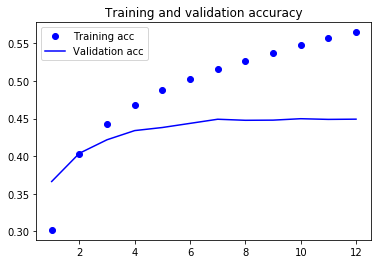

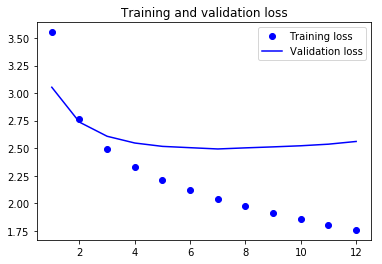

best validation accuracy:  0.4498999996185303


In [116]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(num_words,)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 30,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks = [early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

# Two layers of hidden units
A slight improvement over one layer of hidden units (<1%)

Train on 400000 samples, validate on 20000 samples
Epoch 1/30
400000/400000 [==============================] - 5s 13us/step - loss: 3.0971 - acc: 0.3554 - val_loss: 2.9886 - val_acc: 0.3556
Epoch 2/30
400000/400000 [==============================] - 5s 12us/step - loss: 2.6423 - acc: 0.4227 - val_loss: 2.8742 - val_acc: 0.3792
Epoch 3/30
400000/400000 [==============================] - 5s 12us/step - loss: 2.5115 - acc: 0.4458 - val_loss: 2.8173 - val_acc: 0.3788
Epoch 4/30
400000/400000 [==============================] - 5s 12us/step - loss: 2.4261 - acc: 0.4618 - val_loss: 2.8553 - val_acc: 0.3963
Epoch 5/30
400000/400000 [==============================] - 5s 12us/step - loss: 2.3591 - acc: 0.4743 - val_loss: 2.8572 - val_acc: 0.3921
Epoch 6/30
400000/400000 [==============================] - 5s 12us/step - loss: 2.3025 - acc: 0.4849 - val_loss: 2.8232 - val_acc: 0.4057
Epoch 7/30
400000/400000 [==============================] - 5s 12us/step - loss: 2.2522 - acc: 0.4946 - val_loss: 2

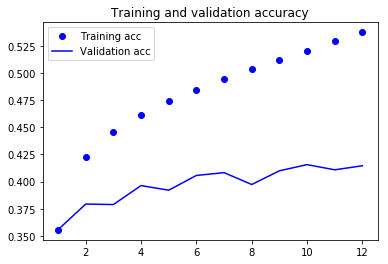

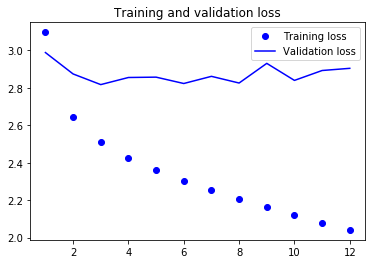

best validation accuracy:  0.41565


In [54]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dense(128, activation='relu', 
                kernel_regularizer = regularizers.l2(0.0025)))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 30,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

## Two layer network with dropout and regularization

Takes longer to train than the network with neither. Some improvements in accuracy but it's a bit marginal.

Train on 400000 samples, validate on 20000 samples
Epoch 1/30
400000/400000 [==============================] - 6s 15us/step - loss: 3.3047 - acc: 0.3126 - val_loss: 2.9831 - val_acc: 0.3421
Epoch 2/30
400000/400000 [==============================] - 6s 15us/step - loss: 2.8429 - acc: 0.3838 - val_loss: 2.8549 - val_acc: 0.3694
Epoch 3/30
400000/400000 [==============================] - 5s 14us/step - loss: 2.7117 - acc: 0.4072 - val_loss: 2.8032 - val_acc: 0.3797
Epoch 4/30
400000/400000 [==============================] - 6s 14us/step - loss: 2.6353 - acc: 0.4221 - val_loss: 2.8180 - val_acc: 0.3864
Epoch 5/30
400000/400000 [==============================] - 5s 13us/step - loss: 2.5772 - acc: 0.4325 - val_loss: 2.7873 - val_acc: 0.3947
Epoch 6/30
400000/400000 [==============================] - 5s 13us/step - loss: 2.5324 - acc: 0.4411 - val_loss: 2.7535 - val_acc: 0.3978
Epoch 7/30
400000/400000 [==============================] - 6s 15us/step - loss: 2.4964 - acc: 0.4477 - val_loss: 2

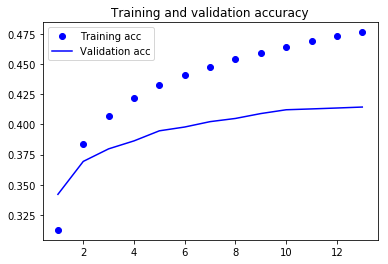

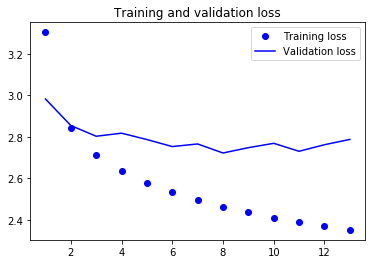

In [56]:
n_output_classes = y_dev_idx.shape[1]

model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(num_words,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu',
                kernel_regularizer = regularizers.l2(0.002)))
model.add(Dropout(0.4))
model.add(Dense(n_output_classes, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_one_hot, y_train_idx,
                    epochs = 30,
                    batch_size = 512,
                    verbose=1,
                    validation_data = (x_dev_one_hot, y_dev_idx),
                    callbacks=[early])

plot_train_history(history)

In [57]:
print ("best validation accuracy: ", max(history.history['val_acc']))

best validation accuracy:  0.4144


# Embedding Layer

First of all, let's try just an embedding layer, into a classifier

In [214]:
x_train[0]

'RT @mydear_bangtan: [VID] 181023 - Foi adicionada a letra “D” no outdoor misterioso do #BTS em Hollywood.\nFormando: BTS AND... \n\n ILOVEPAR…'

Let's assume a maximum sequence length of 25 (shorter sequences will be padded out to this length with zeros)

In [215]:
maxlen = 25

In [216]:
# Tokenize the tweets into lists of words



def convert_to_sequences(tweet_text, tokenizer, maxlen=20):
    tweet_sequence = np.asarray(tokenizer.texts_to_sequences(tweet_text))
    padded = pad_sequences (tweet_sequence, maxlen=maxlen)
    return (padded)

x_train_sequences = convert_to_sequences(x_train, tokenizer, maxlen=maxlen)
x_dev_sequences = convert_to_sequences(x_dev, tokenizer, maxlen=maxlen)
x_test_sequences = convert_to_sequences(x_test, tokenizer, maxlen=maxlen)

Let's inspect the process of turning tweets into integer (word token) sequences.

In [217]:
print ("x_train_sequences.shape:", x_train_sequences.shape)
print ("x_train_sequences[0,:]", x_train_sequences[0,:])
print ("average number of tokenized words per tweet:", np.count_nonzero(x_train_sequences, axis=1).mean())

x_train_sequences.shape: (100000, 25)
x_train_sequences[0,:] [   0    0    0    0    0    0    0    0    0    0    0    0    0    1
 3878 2083 1462    9   68   55   28  958 4649   28   12]
average number of tokenized words per tweet: 11.0488


In [218]:
n_output_classes = y_dev_idx.shape[1]

def simple_embedding_model(num_words, n_output_classes, n_embedding_dims = 16, max_sequence_length = 20):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 

    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 0s 4us/step - loss: 3.6796 - acc: 0.2420 - val_loss: 3.3482 - val_acc: 0.2944
Epoch 2/20
100000/100000 [==============================] - 0s 3us/step - loss: 3.0713 - acc: 0.3496 - val_loss: 3.0227 - val_acc: 0.3557
Epoch 3/20
100000/100000 [==============================] - 0s 3us/step - loss: 2.7897 - acc: 0.3928 - val_loss: 2.8616 - val_acc: 0.3876
Epoch 4/20
100000/100000 [==============================] - 0s 3us/step - loss: 2.6092 - acc: 0.4229 - val_loss: 2.7646 - val_acc: 0.4073
Epoch 5/20
100000/100000 [==============================] - 0s 3us/step - loss: 2.4704 - acc: 0.4476 - val_loss: 2.7017 - val_acc: 0.4144
Epoch 6/20
100000/100000 [==============================] - 0s 3us/step - loss: 2.3548 - acc: 0.4682 - val_loss: 2.6552 - val_acc: 0.4214
Epoch 7/20
100000/100000 [==============================] - 0s 3us/step - loss: 2.2544 - acc: 0.4857 - val_loss: 2.6214 -

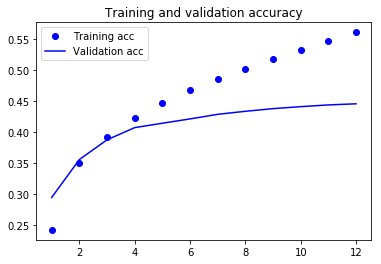

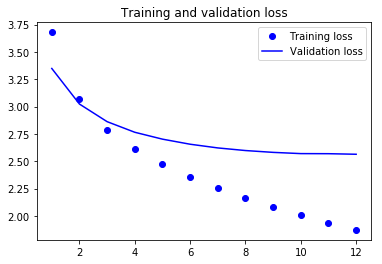

In [122]:
clear_session()

model = simple_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 64, 
                               max_sequence_length = maxlen)    

early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=1, mode='auto')

checkpoint = keras.callbacks.ModelCheckpoint(filepath='emoji_embedding.h5',
                                             monitor='val_acc',
                                             save_best_only = True)

tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log',
                                          #write_grads=1,
                                          #histogram_freq=1,
                                          embeddings_freq=1,
                                          embeddings_data='embedding') ## ?? How to implement this

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 20,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)

In [123]:
print ("best validation accuracy: ", max(history.history['val_acc']))

best validation accuracy:  0.44579999980926516


In [124]:
def deeper_embedding_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           dense2_size = 16,
                           dropout2_rate = 0.2,
                           lambd = 0.0):

    model = Sequential()

    # 8-dimensional embedding layer for 1,000 words
    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 

    # flattens 3D tensor of embeddings into 2D tensor of shape (samples, maxlen * 8)
    model.add(Flatten()) 
    
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    model.add(Dense(dense2_size, activation='relu',
                    kernel_regularizer = regularizers.l2(lambd)))
    model.add(Dropout(dropout2_rate))
    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 2s 15us/step - loss: 4.1061 - acc: 0.1443 - val_loss: 3.7617 - val_acc: 0.1986
Epoch 2/50
100000/100000 [==============================] - 0s 5us/step - loss: 3.6523 - acc: 0.2297 - val_loss: 3.5452 - val_acc: 0.2425
Epoch 3/50
100000/100000 [==============================] - 1s 13us/step - loss: 3.4597 - acc: 0.2515 - val_loss: 3.4015 - val_acc: 0.2503
Epoch 4/50
100000/100000 [==============================] - 2s 16us/step - loss: 3.3226 - acc: 0.2697 - val_loss: 3.2813 - val_acc: 0.2871
Epoch 5/50
100000/100000 [==============================] - 2s 18us/step - loss: 3.2115 - acc: 0.2872 - val_loss: 3.1948 - val_acc: 0.3015
Epoch 6/50
100000/100000 [==============================] - 2s 16us/step - loss: 3.1268 - acc: 0.3003 - val_loss: 3.1289 - val_acc: 0.3131
Epoch 7/50
100000/100000 [==============================] - 2s 17us/step - loss: 3.0488 - acc: 0.3122 - val_loss: 3.

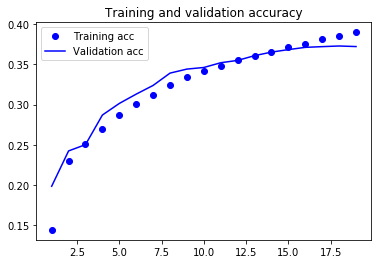

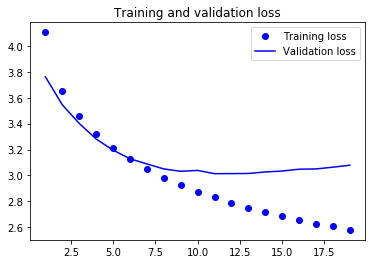

best validation accuracy:  0.37290000014305114


In [125]:
clear_session()

model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 28, 
                               max_sequence_length = maxlen,
                               lambd = 0.0006)    

early = keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

Conclusions:
The embedding->shallow NN model struggles to get above 31% accuracy. Actually best results obtained when number of embedding dimensions is small: ~3-4. 

# Using pretrained (GloVe) word embeddings

In [219]:
# A utility function to load in the GloVe word/index/vector embeddings

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map, words

In [220]:
#Load the pretrained embeddings
# 400,001 words (0-400000), 50 dimensions  

word_to_index, index_to_word, word_to_vec_map, words = read_glove_vecs('glove.6B.50d.txt')

In [251]:
#Re-tokenize the tweets using the GloVe encodings. 

def sentences_to_indices(X, word_to_index, words, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros(shape=(m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        # could also filter eg for twitter handles here, but tokenizing will get rid of them
        
        # Initialize j to 0
        w, j_source, j_fin = 0, 0, 0
        
        # Loop over the words of sentence_words
        while w < min(len(sentence_words), max_len):
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if sentence_words[w] in words:
                X_indices[i, j_fin] = word_to_index[sentence_words[w]]
                # only increment the destination idx if we recognised/wrote the previous word
                j_fin = j_fin+1 
            w = w+1
            j_source = j_source+1
    
    return X_indices

In [252]:
tweets.loc[0:9]['text']

0    RT @mydear_bangtan: [VID] 181023 - Foi adicion...
1    RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...
2    RT @TrendsPrabhas: Now you are watching Indian...
3                                      dats for keeps 
4                 @Eric_Deshaun Holy shit no I think. 
5       RT @fanmutuals: army, follow who retweet this 
6    RT @_Simplykpop: Simply K-Pop harddrive dump\n...
7    Happy birthday nellie @thelittlegend, hope you...
8    RT @montparnasty: "I have passed through fire"...
9    RT @hellohonne: Incredible to be involved in t...
Name: text, dtype: object

In [253]:
X1 = tweets.loc[0:9]['text']
X1_indices = sentences_to_indices(X1,word_to_index, words, max_len = 15)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = 0    RT @mydear_bangtan: [VID] 181023 - Foi adicion...
1    RT @WuYiFan_KrisBar: 181023 Kris Wu Studio upd...
2    RT @TrendsPrabhas: Now you are watching Indian...
3                                      dats for keeps 
4                 @Eric_Deshaun Holy shit no I think. 
5       RT @fanmutuals: army, follow who retweet this 
6    RT @_Simplykpop: Simply K-Pop harddrive dump\n...
7    Happy birthday nellie @thelittlegend, hope you...
8    RT @montparnasty: "I have passed through fire"...
9    RT @hellohonne: Incredible to be involved in t...
Name: text, dtype: object
X1_indices = [[312561.    614. 150873.  43010. 220925. 262350. 273028. 246362. 126552.
       0.      0.      0.      0.      0.      0.]
 [312561. 212512. 390642. 345175. 373375. 219705. 111465.  62065. 357266.
  260309. 362050.      0.      0.      0.      0.]
 [312561. 264937. 394475.  58997. 383753. 189140. 348079. 388711. 396799.
  134136.  54718. 396799.      0.      0.      0.]
 [117580. 151349. 204686.      

In [247]:
X1 = tweets.loc[0:9]['text']
sen_wds = X1[2].lower().split()
sen_wds[1]

'@trendsprabhas:'

In [186]:
# Create an embedding layer to use the 50-dimensional GloVe vectors
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable.
    embedding_layer = Embedding(input_dim = vocab_len, output_dim=50, trainable=True)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## Tuning parameters for a much bigger (100,000) tweet training dataset

In [12]:
clear_session()

model = deeper_embedding_model(num_words,
                               n_output_classes, 
                               n_embedding_dims = 128,          #196      # 128
                               max_sequence_length = maxlen,
                               dense1_size = 128,               # 160     # 128
                               dropout1_rate = 0.4,           # 0.35
                               dense2_size = 96,             # 128   # 96
                               dropout2_rate = 0.4,           # 0.35
                               lambd = 0.0025)                # 0.0015

                           
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=10,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

NameError: name 'deeper_embedding_model' is not defined

# Simple LSTM model

In [18]:
def simple_lstm_model(num_words,
                           n_output_classes, 
                           n_embedding_dims = 16, 
                           max_sequence_length = 20, 
                           dense1_size = 16, 
                           dropout1_rate = 0.2,
                           lambd = 0.0):

    model = Sequential()

    model.add(Embedding(num_words, n_embedding_dims, input_length = max_sequence_length, name="embedding")) 
    model.add(LSTM(n_embedding_dims))
    # model.add(Flatten()) 
    
    model.add(Dense(dense1_size, activation='relu'))
    model.add(Dropout(dropout1_rate))
    model.add(Dense(n_output_classes, activation = 'softmax'))
    model.compile(optimizer = 'rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return (model)

In [21]:
clear_session()

model = simple_lstm_model(num_words,
                          n_output_classes, 
                          n_embedding_dims = 90,          
                          max_sequence_length = maxlen,
                          dense1_size = 128,               
                          dropout1_rate = 0.2,           
                          lambd = 0.0025)                

tensorboard = keras.callbacks.TensorBoard(log_dir='tensorboard_log')
                                          #write_grads=1,
                                          #histogram_freq=1,
                                          #embeddings_freq=1,
                                          #embeddings_data='embedding') ## ?? How to implement this


early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=5,
                              verbose=1, mode='auto')

history = model.fit (x_train_sequences, y_train_idx,
                     validation_data = (x_dev_sequences, y_dev_idx),
                     epochs = 50,
                     batch_size = 512,
                     verbose=1,
                     callbacks=[early, tensorboard])

plot_train_history(history)
print ("best validation accuracy: ", max(history.history['val_acc']))

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 165s 2ms/step - loss: 3.5218 - acc: 0.2257 - val_loss: 3.3117 - val_acc: 0.2564
Epoch 2/50
100000/100000 [==============================] - 147s 1ms/step - loss: 2.9270 - acc: 0.3226 - val_loss: 2.9655 - val_acc: 0.3157
Epoch 3/50
100000/100000 [==============================] - 159s 2ms/step - loss: 2.6227 - acc: 0.3853 - val_loss: 2.9134 - val_acc: 0.3280
Epoch 4/50
100000/100000 [==============================] - 152s 2ms/step - loss: 2.4562 - acc: 0.4210 - val_loss: 2.7880 - val_acc: 0.3452
Epoch 5/50
100000/100000 [==============================] - 168s 2ms/step - loss: 2.3499 - acc: 0.4450 - val_loss: 2.7140 - val_acc: 0.3683
Epoch 6/50
100000/100000 [==============================] - 166s 2ms/step - loss: 2.2755 - acc: 0.4602 - val_loss: 2.7755 - val_acc: 0.3613
Epoch 7/50
100000/100000 [==============================] - 157s 2ms/step - loss: 2.2170 - acc: 0.4722 - val_

NameError: name 'plot_train_history' is not defined